In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/ann challenge

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/ann challenge


### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
# Import other libraries
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns
plt.rc('font', size=16)
sns.set_theme()

## Auxiliary functions

In [ ]:
def plot_time_series(x: np.ndarray) -> None:
  plt.figure(figsize=(16, 4))
  plt.plot(x)
  plt.title(f"Time series")
  plt.show()

In [ ]:
def plot_history(history, log_scale: bool = False) -> None:
  mae = history['mae']
  val_mae = history['val_mae']
  loss = history['loss']
  val_loss = history['val_loss']
  best_epoch = np.argmin(val_loss)

  plt.figure(figsize=(18, 6))
  plt.subplot(1, 2, 1)
  plt.title('Training and validation MSE')
  plt.xlabel('Epoch')
  plt.ylabel('Mean Squared Error')

  if log_scale:
      plt.semilogy(loss, label='Training MSE', color='#ff7f0e')
      plt.semilogy(val_loss, label='Validation MSE', color='#4D61E2')
  else:
      plt.plot(loss, label='Training MSE', color='#ff7f0e')
      plt.plot(val_loss, label='Validation MSE', color='#4D61E2')

  plt.plot(best_epoch, history['val_loss'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
  plt.grid(True)
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.title('Training and validation MAE')
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Error')

  if log_scale:
     plt.semilogy(mae, label='Training MAE', color='#ff7f0e')
     plt.semilogy(val_mae, label='Validation MAE', color='#4D61E2')
  else:
    plt.plot(mae, label='Training MAE', color='#ff7f0e')
    plt.plot(val_mae, label='Validation MAE', color='#4D61E2')

  plt.plot(best_epoch, history['val_mae'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
  plt.grid(True)
  plt.legend()
  plt.show()

## Load data

In [ ]:
data = np.load('preprocessed_data_stride_50.npz', allow_pickle=True)

In [ ]:
X_train, X_val, y_train, y_val = data["X_train"], data["X_val"], data["y_train"], data["y_val"]

In [ ]:
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
y_val= np.expand_dims(y_val, axis=-1)

In [ ]:
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (154277, 200, 1)
Training Label Shape: (154277, 9, 1)
Validation Data Shape: (17142, 200, 1)
Validation Label Shape: (17142, 9, 1)


## Build the model

In [ ]:
# Define key model parameters
input_shape = X_train.shape[1:]         # Input shape for the model
output_shape = y_train.shape[1:]        # Output shape for the model
batch_size = 256                        # Batch size for training
epochs = 200                            # Number of training epochs

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Epochs: 200
Batch Size: 256
Input Shape: (200, 1)
Output Shape: (9, 1)


In [ ]:
initializer = tf.keras.initializers.HeNormal()
model_name = 'we_dont_need_attention'

def build_model(input_shape, output_shape):
  # Ensure the input time steps are at least as many as the output time steps
  assert input_shape[0] >= output_shape[0]

  # Define the input layer with the specified shape
  input_layer = tfkl.Input(shape=input_shape, name='Input')
  x = tfkl.LSTM(150)(input_layer)
  x = tfkl.RepeatVector(200)(x)
  x = tfkl.LSTM(150, return_sequences=True)(x)
  x = tfkl.TimeDistributed(tfkl.Dense(64, activation='softmax'))(x)

  x = tfkl.Multiply()([input_layer, x])
  bilstm = tfkl.Bidirectional(tfkl.LSTM(288, return_sequences=True))(x) # 256
  bilstm = tfkl.Bidirectional(tfkl.LSTM(192))(bilstm) # 256
  dropout = tfkl.Dropout(0.2, seed=seed)(bilstm) # 0.3

  x = tfkl.Flatten()(x)

  x = tfkl.Dense(units=1024, kernel_initializer=initializer)(x)
  x = tfkl.Activation('relu')(x)
  x = tfkl.Dropout(0.2)(x)

  output_layer = tfkl.Dense(9, activation='linear')(x)

  # Construct the model by connecting input and output layers
  model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name=model_name)

  # Compile the model with Mean Squared Error loss and Adam optimizer
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['mae'])

  return model

In [ ]:
model = build_model(input_shape, output_shape)
model.summary()

Model: "we_dont_need_attention"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 200, 1)]             0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 150)                  91200     ['Input[0][0]']               
                                                                                                  
 repeat_vector (RepeatVecto  (None, 200, 150)             0         ['lstm[0][0]']                
 r)                                                                                               
                                                                                                  
 lstm_1 (LSTM)               (None, 200, 150)             180600    ['repeat_

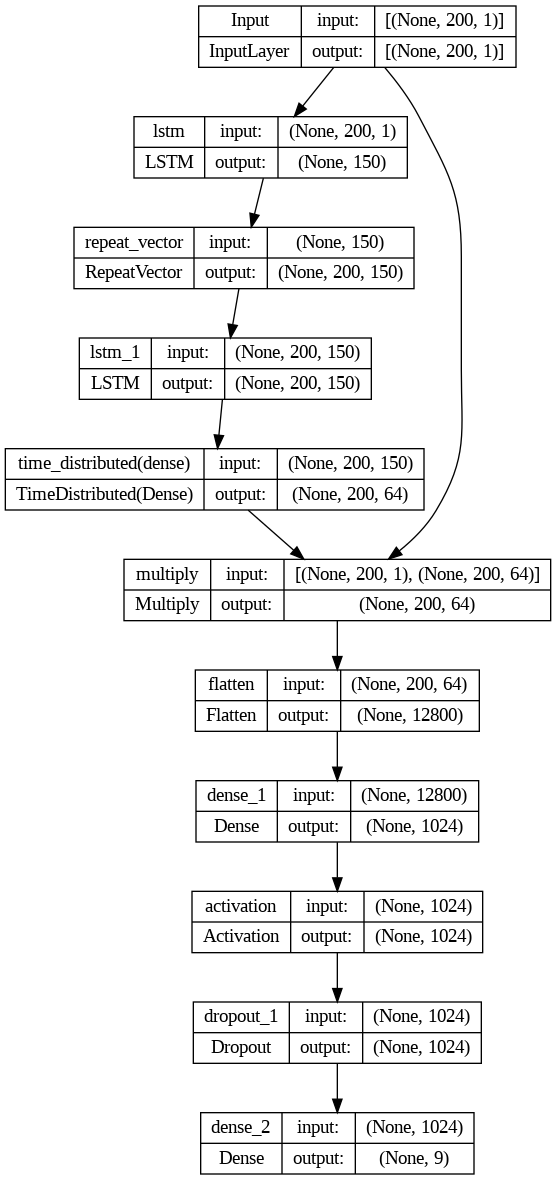

In [ ]:
tfk.utils.plot_model(model, show_shapes=True)

In [ ]:
lr_patience = 10
es_patience = 25
callbacks = [
    tfk.callbacks.TerminateOnNaN(),
    tfk.callbacks.ReduceLROnPlateau('val_loss', patience=lr_patience, factor=0.3, min_lr=1e-5, verbose=1),
    tfk.callbacks.EarlyStopping('val_loss', patience=es_patience, restore_best_weights=True, verbose=1),
    tfk.callbacks.ModelCheckpoint(filepath='checkpoints/' + model.name + '/', save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)
]

## Train model

In [ ]:
# Train the model and save its history
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
).history

Epoch 1/200
603/603 [==============================] - 55s 73ms/step - loss: 0.0140 - mae: 0.0800 - val_loss: 0.0104 - val_mae: 0.0687 - lr: 0.0010
Epoch 2/200
603/603 [==============================] - 44s 72ms/step - loss: 0.0105 - mae: 0.0694 - val_loss: 0.0094 - val_mae: 0.0631 - lr: 0.0010
Epoch 3/200
603/603 [==============================] - 43s 71ms/step - loss: 0.0100 - mae: 0.0672 - val_loss: 0.0094 - val_mae: 0.0649 - lr: 0.0010
Epoch 4/200
603/603 [==============================] - 44s 73ms/step - loss: 0.0097 - mae: 0.0658 - val_loss: 0.0088 - val_mae: 0.0608 - lr: 0.0010
Epoch 5/200
603/603 [==============================] - 43s 72ms/step - loss: 0.0094 - mae: 0.0647 - val_loss: 0.0087 - val_mae: 0.0619 - lr: 0.0010
Epoch 6/200
603/603 [==============================] - 43s 72ms/step - loss: 0.0091 - mae: 0.0639 - val_loss: 0.0083 - val_mae: 0.0590 - lr: 0.0010
Epoch 7/200
603/603 [==============================] - 44s 73ms/step - loss: 0.0089 - mae: 0.0629 - val_loss: 0.

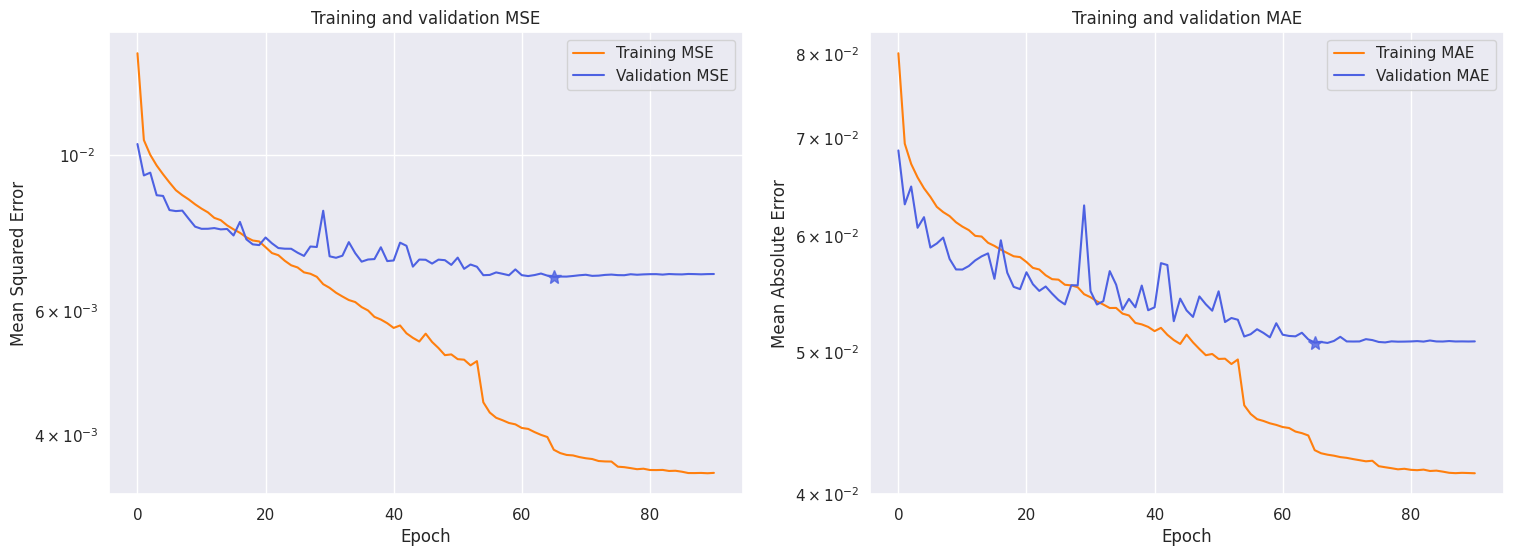

In [ ]:
plot_history(history, log_scale=True)

In [ ]:
mse, mae = model.evaluate(X_val, y_val)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

536/536 [==============================] - 5s 10ms/step - loss: 0.0067 - mae: 0.0508
Mean Squared Error: 0.006711297668516636
Mean Absolute Error: 0.050771716982126236


In [ ]:
# Save the trained model
model.save('models/' + model.name)

In [ ]:
# del model

In [ ]:
# model = tfk.models.load_model('models/ResNet2B_CONV1D_BiGRU_with_stride_model')

In [ ]:
telescope = 9
samples_to_predict = telescope * 2
test_sequences = X_val[0:60]
sequences = np.copy(test_sequences)

i = 0
while i*telescope < samples_to_predict:
  pred = model.predict(sequences[:,:])
  for j in range(len(sequences)):
    for z in range(len(pred[j])):
      sequences[j] = np.delete(np.append(sequences[j], pred[j][z]), 0).reshape(-1, 1)
  i += 1

In [ ]:
def plot_data_and_target(data, target, original = None):
  # Remove padding from the data
  data = data[np.nonzero(data)[0][0]:]
  # Generate indexes to align the time stamps
  indexes = np.arange(0, len(data) + len(target))

  # Plot the new data and the new target
  plt.figure(figsize=(16, 4))
  plt.plot(indexes[:len(data)], data, label='data', linewidth=2)
  plt.plot(indexes[len(data):], target, label='target', linewidth=2)

  if original is not None:
    # Plot the original data
    plt.plot(indexes, original, label='original', linestyle='--')

  plt.title("Time series")
  plt.legend()
  plt.show()

In [ ]:
index = np.random.randint(len(test_sequences))
plot_data_and_target(test_sequences[index], sequences[index,-samples_to_predict:])